In [1]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import time

from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from torch import nn
from torchvision import transforms
from DatasetMedical import DatasetCAMUS_r, DatasetCAMUS
from Unet2D import Unet2D
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
from torchvision.transforms import ToPILImage
from medimage import image as medim

In [6]:
base_path = Path('/work/datasets/medical_project/CAMUS')
data = DatasetCAMUS(base_path)

y_max = 0
y_min = np.inf
x_max = 0
x_min = np.inf

max_shape = (0, 0)
min_shape = (0, np.inf)

file_number = 0

max_file = None
min_file = None

for i, f in enumerate(data.files):
    x = f['gray'].header['DimSize'][0]
    y = f['gray'].header['DimSize'][1]
    
    if y > y_max:
        file_number = i
        y_max = y
        max_shape = (x, y)
        max_file = f
        
    if x > x_max:
        x_max = x
    
    if x < x_min:
        x_min = x   
    
    if y < y_min:
        y_min = y
        min_shape = (x, y)
        min_file = f



patient0004_4CH_ED.mhd loaded. Shape: (641, 908, 1)
patient0004_4CH_ED_gt.mhd loaded. Shape: (641, 908, 1)
patient0134_4CH_ED.mhd loaded. Shape: (482, 843, 1)
patient0134_4CH_ED_gt.mhd loaded. Shape: (482, 843, 1)
patient0008_4CH_ED.mhd loaded. Shape: (787, 1297, 1)
patient0008_4CH_ED_gt.mhd loaded. Shape: (787, 1297, 1)
patient0017_4CH_ED.mhd loaded. Shape: (630, 1038, 1)
patient0017_4CH_ED_gt.mhd loaded. Shape: (630, 1038, 1)
patient0411_4CH_ED.mhd loaded. Shape: (512, 843, 1)
patient0411_4CH_ED_gt.mhd loaded. Shape: (512, 843, 1)
patient0399_4CH_ED.mhd loaded. Shape: (624, 973, 1)
patient0399_4CH_ED_gt.mhd loaded. Shape: (624, 973, 1)
patient0011_4CH_ED.mhd loaded. Shape: (512, 843, 1)
patient0011_4CH_ED_gt.mhd loaded. Shape: (512, 843, 1)
patient0067_4CH_ED.mhd loaded. Shape: (551, 908, 1)
patient0067_4CH_ED_gt.mhd loaded. Shape: (551, 908, 1)
patient0151_4CH_ED.mhd loaded. Shape: (708, 1167, 1)
patient0151_4CH_ED_gt.mhd loaded. Shape: (708, 1167, 1)
patient0108_4CH_ED.mhd loaded. 

Max in y dimension: 1945
Min in y dimension: 584
Max in x dimension: 1181
Min in x dimension: 323
Max shape: (1181, 1945)
Min shape: (355, 584)
Displaying image 147


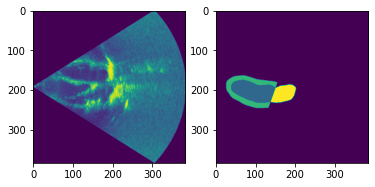

In [7]:
print(f'Max in y dimension: {y_max}')
print(f'Min in y dimension: {y_min}')
print(f'Max in x dimension: {x_max}')
print(f'Min in x dimension: {x_min}')
print(f'Max shape: {max_shape}')
print(f'Min shape: {min_shape}')

print(f'Displaying image {file_number}')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(data.open_as_array(file_number))
ax[1].imshow(data.open_mask(file_number))
plt.show()

In [8]:
def open_photo(file, isotropic=False):
    im = file['gray']
    arr = np.array(im.imdata)
    pil_im = ToPILImage()(arr)
    #pil_im = self.resize_image(pil_im)
    if isotropic:
        pil_isotropic = pil_im.resize((pil_im.size[0], pil_im.size[1]//2))
        pil_im = Image.new(pil_im.mode, (1945, 1181//2), 0)
        pil_im.paste(pil_isotropic)
        #pil_im = pil_im.resize((384, 384))

    print(pil_im.size)
    raw_us = np.stack([np.array(pil_im),], axis=2)

    # normalize
    return (raw_us / np.iinfo(raw_us.dtype).max)

def open_mask(file, isotropic=False):
    im = file['gt']
    arr = np.array(im.imdata)
    pil_im = ToPILImage()(arr)
    #pil_im = self.resize_image(pil_im)
    if isotropic:
        pil_isotropic = pil_im.resize((pil_im.size[0], pil_im.size[1]//2))
        pil_im = Image.new(pil_im.mode, (1945, 1181//2), 0)
        pil_im.paste(pil_isotropic)
        #pil_im = pil_im.resize((384, 384))
        
        
    raw_mask = np.array(pil_im) # a numpy array with unique values [0,1,2,3]

    return raw_mask

[1181, 1945, 1]
[0.308, 0.154, 1.54]
Displaying raw image
(1945, 1181)


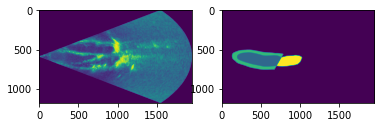

Displaying raw image made isotropic (max image)
(1945, 590)


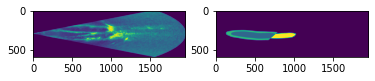

Displaying raw image made isotropic (min image)
(1945, 590)


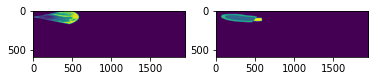

In [9]:
print(file['gray'].header['DimSize'])
print(file['gray'].header['ElementSpacing'])

print(f'Displaying raw image')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(open_photo(file))
ax[1].imshow(open_mask(file))
plt.show()

print(f'Displaying raw image made isotropic (max image)')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(open_photo(max_file, True))
ax[1].imshow(open_mask(max_file, True))
plt.show()

print(f'Displaying raw image made isotropic (min image)')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(open_photo(min_file, True))
ax[1].imshow(open_mask(min_file, True))
plt.show()